Key reference : https://arxiv.org/abs/1505.05770

Translated to TensorFlow from : https://github.com/casperkaae/parmesan/blob/master/parmesan/layers/flow.py



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from utils import Param
from gpflow import transforms
import matplotlib
from numpy.random import RandomState
prng = RandomState(1231)

tfd = tf.contrib.distributions
FLOAT_TYPE = tf.float32

** Model specifications **

In [2]:
################################
test_energy_fun= 1      # energy function to test : range 1 - 4

lr = 1e-2               # optimization params
niterations = 50000
batch_size = 100

use_linear_nf0 = True     # use linear flow in the first layer
use_annealed_loss = False # use annelaing for first 40k iterations

nflows = 12             # number of flow layers 
use_planar_flow = False # True : "planar" or False : "radial"

tbPath = "tensorboard"  # tensorboard specs
write_tf_summary = False
################################

** Normalizing flow classes **

In [3]:
class PlanarFlow:
    def __init__(self,u_init,w_init,b_init, name="planar_flow"):
        u = Param(value=u_init, name = "u_"+name,summ=True).get_tfv()
        w = Param(value=w_init, name = "w_"+name,summ=True).get_tfv()
        b = Param(value=b_init, name = "b_"+name,summ=True).get_tfv()
                
        self.u = u
        self.w = w
        self.b = b

    def forward(self, z):
        uw = tf.reduce_sum(tf.multiply(self.u,self.w))
        muw = -1.0 + tf.nn.softplus(uw) 
        
        u_hat = self.u + (muw - uw) * self.w / tf.reduce_sum(tf.square(self.w))
        zwb = tf.reduce_sum(tf.multiply(z,self.w),axis=1) + self.b
        zwb = tf.expand_dims(zwb,1)
        f_z = z + tf.multiply(u_hat,tf.tanh(zwb))
        
        psi = tf.multiply(1.0-tf.square(tf.tanh(zwb)),self.w)
        psi_u = tf.reduce_sum(tf.multiply(psi,u_hat),axis=1)
        
        logdet_jacobian = tf.log(tf.abs(1.0 + psi_u))
        return f_z, logdet_jacobian
    
class RadialFlow:
    def __init__(self,zo_init,alpha_init,beta_init, name="planar_flow"):
        zo = Param(value=zo_init, name = "zo_"+name,summ=True).get_tfv()
        alpha = Param(alpha_init,transforms.positive, name = "alpha_"+name,summ=True).get_tfv()
        beta = Param(value=beta_init, name = "beta_"+name,summ=True).get_tfv()
                
        self.zo = zo
        self.alpha = alpha
        self.beta = beta
        

    def forward(self, z):
        beta_hat = -self.alpha + tf.nn.softplus(self.beta)
        r = tf.reduce_sum(tf.abs(tf.subtract(z,self.zo)),axis=1)
        h_ar = 1.0 /(self.alpha + r)
        f_z = z + beta_hat*tf.multiply(tf.expand_dims(h_ar,1),(z-self.zo))
        
        dh_ar = -1/(self.alpha + r)**2
        logdet_jacobian = (tf.cast(tf.shape(self.zo)[1],dtype=FLOAT_TYPE) -1)* tf.log(1.0 + beta_hat*h_ar)\
                          + tf.log(1.0 + beta_hat*h_ar+ beta_hat * tf.multiply(dh_ar,r))
                          
        return f_z, logdet_jacobian    
    
class LinearFlow:
    def __init__(self, mu_init,log_var_init,name="linear_flow"):
        mu = Param(value=mu_init, name = "mu_"+name,summ=True).get_tfv()
        log_var = Param(value=log_var_init,name = "logvar_"+name,summ=True).get_tfv()
            
        self.mu = mu
        self.log_var = log_var
    
    def forward(self,z):
        sigma = tf.exp(0.5*self.log_var)
        f_z = self.mu + tf.multiply(z,sigma)
        
        logdet_jacobian = tf.reduce_sum(0.5*self.log_var,axis=1)
        logdet_jacobian = tf.tile(logdet_jacobian,[tf.shape(z)[0]])
        return f_z, logdet_jacobian 

In [4]:
def U_z(z,test_energy_fun=2):
    """Test energy function U(z)."""
    z1 = z[:,0]
    z2 = z[:,1]

    if test_energy_fun == 1:
        return 0.5*((tf.sqrt(z1**2 + z2**2) - 2.)/0.4)**2 - tf.log(tf.exp(-0.5*((z1 - 2.)/0.6)**2) + tf.exp(-0.5*((z1 + 2.)/0.6)**2))
    elif test_energy_fun == 2:
        w1 = tf.sin((2.*np.pi*z1)/4.)
        return 0.5*((z2 - w1) / 0.4)**2
    elif test_energy_fun == 3:
        w1 = tf.sin((2.*np.pi*z1)/4.)
        w2 = 3.*tf.exp(-0.5*((z1 - 1.)/0.6)**2)
        return -tf.log(tf.exp(-0.5*((z2 - w1)/0.35)**2) + tf.exp(-0.5*((z2 - w1 + w2)/0.35)**2))
    elif test_energy_fun == 4:
        w1 = tf.sin((2.*np.pi*z1)/4.)
        w3 = 3.*tf.nn.sigmoid((z1 - 1.)/0.3)**4
        return -tf.log(tf.exp(-0.5*((z2 - w1)/0.4)**2) + tf.exp(-0.5*((z2 - w1 + w3)/0.35)**2))
    else:
        raise ValueError('invalid `test_energy_fun`')
        
        
def evaluate_bivariate_pdf(p_z, range, npoints):
    """Evaluate pdf over a 2D meshgrid."""
   
    side = np.linspace(range[0], range[1], npoints)
    z1, z2 = np.meshgrid(side, side)
    z = np.hstack([z1.reshape(-1, 1), z2.reshape(-1, 1)])

    p_z_ = p_z.eval(feed_dict = {z0:z})
   
    return z1, z2, p_z_.reshape(z1.shape)


In [5]:
with tf.name_scope("input"):
    z0 = tf.placeholder(dtype=FLOAT_TYPE)

l_zk_list = [z0]
l_nf_list = []
l_logdet_J_list = []


with tf.name_scope("flow_param"):
    if use_linear_nf0 :
        mu0 = prng.randn(1,2)*1e-1
        logvar0 = prng.randn(1,2)*1e-
        l_nf = LinearFlow(mu_init=mu0,
                          log_var_init=logvar0,
                          name='NF_0')
        l_zk, l_logdet_J = l_nf.forward(l_zk_list[-1])

        tf.summary.histogram('zK0',l_zk)
        tf.summary.histogram('logdet_J0',l_logdet_J)

        l_nf_list += [l_nf]
        l_zk_list += [l_zk]
        l_logdet_J_list += [l_logdet_J]
    
    if use_planar_flow:
        for k in range(nflows):
            u0 = prng.randn(1,2) * 1e-1
            w0 = prng.randn(1,2) * 1e-1
            b0 = prng.randn() * 1e-1

            l_nf = PlanarFlow(u_init = u0,
                              w_init = w0,
                              b_init =  b0,
                              name='NF_{:d}'.format(1+k))

            l_zk, l_logdet_J = l_nf.forward(l_zk_list[-1])

            tf.summary.histogram('zK{:d}'.format(1+k),l_zk)
            tf.summary.histogram('logdet_J{:d}'.format(1+k),l_logdet_J)

            l_nf_list += [l_nf]
            l_zk_list += [l_zk]
            l_logdet_J_list += [l_logdet_J]

    else:        
        for k in range(nflows):
            zo0 = np.random.randn(1,2) * 1e-1
            beta0 = np.random.randn() * 1e-1
            alpha0 = np.abs(np.random.randn() * 1e-1)

            l_nf = RadialFlow(zo_init = zo0,
                              beta_init = beta0,
                              alpha_init =  alpha0,
                              name='NF_{:d}'.format(1+k))

            l_zk, l_logdet_J = l_nf.forward(l_zk_list[-1])

            tf.summary.histogram('zK{:d}'.format(1+k),l_zk)
            tf.summary.histogram('logdet_J{:d}'.format(1+k),l_logdet_J)

            l_nf_list += [l_nf]
            l_zk_list += [l_zk]
            l_logdet_J_list += [l_logdet_J]

In [6]:
with tf.name_scope("model_build"):
    stdnormal = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1., 1.])
    log_q0_z0 = stdnormal.log_prob(z0)
    sum_logdet_J = tf.add_n(l_logdet_J_list)
    log_qK_zK = log_q0_z0 - sum_logdet_J
    log_pX_zK = U_z(l_zk_list[-1],test_energy_fun)
    
    tf.summary.histogram('log_q0_z0',log_q0_z0)
    tf.summary.histogram('sum_logdet_J',sum_logdet_J)
    tf.summary.histogram('log_qK_zK',log_qK_zK)
    tf.summary.histogram('log_pX_zK',log_pX_zK)

with tf.name_scope("kl"):
    if use_annealed_loss:
        
        iteration_counter = tf.Variable(1, name='iteration_counter', trainable=False, dtype=tf.int32)
        iteration_counter_op = tf.assign(iteration_counter, iteration_counter+1)

        beta_t = tf.minimum(1.0, 0.01 + tf.cast(iteration_counter,dtype=FLOAT_TYPE)/10000.)
        tf.summary.scalar('beta_t',beta_t)
        
        kl = tf.reduce_mean(log_qK_zK + tf.multiply(tf.cast(beta_t,dtype=FLOAT_TYPE),log_pX_zK))
    else:

        kl = tf.reduce_mean(log_qK_zK + log_pX_zK)
    
    tf.summary.scalar('kl', kl)

    
# train functions
loss = kl
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

In [7]:
def _plot_planarflow(fig,axlist):
  
    ax = axlist[0]
    mesh_z1, mesh_z2, phat_z = evaluate_bivariate_pdf(tf.exp(-U_z(z0,test_energy_fun)), range=(-4, 4), npoints=200)
    ax.pcolormesh(mesh_z1, mesh_z2, phat_z)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.invert_yaxis()
    ax.set_title('$p(z)$')

    log_q0_z1 = log_q0_z0 - l_logdet_J_list[0]
    ax = axlist[1]
    mesh_z1, mesh_z2, q0_z0_ = evaluate_bivariate_pdf(tf.exp(log_q0_z1), range=(-4, 4), npoints=200)
    ax.pcolormesh(mesh_z1, mesh_z2, q0_z0_)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.invert_yaxis()
    ax.set_title('$q_0(z)$')
    
    ax = axlist[2]
    mesh_z1, mesh_z2, log_det_zK_ = evaluate_bivariate_pdf(tf.exp(sum_logdet_J), range=(-4, 4), npoints=400)
    ax.pcolormesh(mesh_z1, mesh_z2, log_det_zK_)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.invert_yaxis()
    ax.set_title('$log J$')
    
    ax = axlist[3]
    mesh_z1, mesh_z2, qK_zK_ = evaluate_bivariate_pdf(tf.exp(log_qK_zK), range=(-4, 4), npoints=400)
    ax.pcolormesh(mesh_z1, mesh_z2, qK_zK_)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.invert_yaxis()
    ax.set_title('$q_K(z_K)$')

    ax = axlist[4]
    N = 50000
    z0_ = np.random.normal(size=(N, 2))
    zK  = l_zk_list[-1]
    zK_ = zK.eval(feed_dict={z0:z0_})
    ax.hist2d(zK_[:, 0], zK_[:, 1], range=[[-4, 4], [-4, 4]], bins=200)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.invert_yaxis()
    ax.set_title('$z_K \sim q_K(z)$')
    
    for ax in axlist:
        ax.set(adjustable='box-forced', aspect='equal')

    fig.canvas.draw()

In [8]:
sess = tf.InteractiveSession()

# tensorboard summary
summary_merged = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(tbPath,graph=sess.graph)

sess.run(tf.global_variables_initializer())

<IPython.core.display.Javascript object>


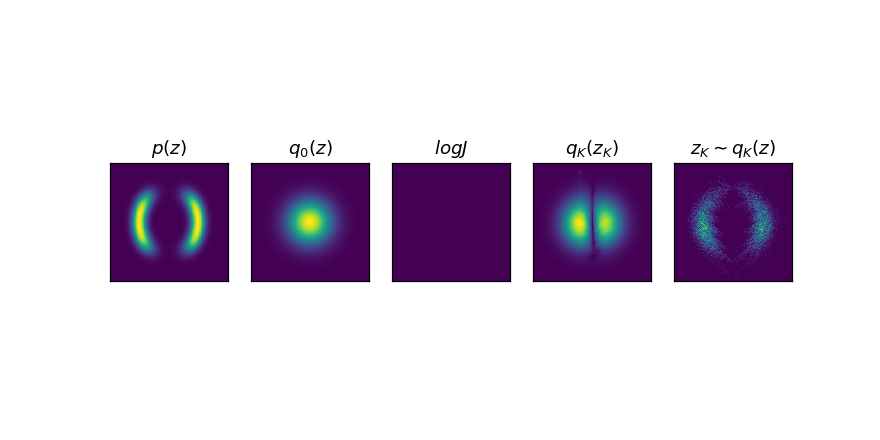

training started:
iterations --   log prob


In [9]:
% matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (8.0,4.0)
fig,axlist = plt.subplots(1, 5)


print('training started:')
print('{:>10s}'.format("iterations") + " -- "+ '{:>10s}'.format("log prob"))

for i in range(int(niterations)):
    try:
        _z0 = prng.normal(size=(batch_size, 2))
        if use_annealed_loss:
            sess.run(iteration_counter_op)
        
        if write_tf_summary:
            summary,_, np_loss = sess.run([summary_merged,train_op,loss],feed_dict={z0:_z0})

            if i % 100 == 0:
                summary_writer.add_summary(summary,i)
                summary_writer.flush()

        else:
            _, np_loss = sess.run([train_op,loss],feed_dict={z0:_z0})

        if i % 1000 == 0:
            print('{:>10d}'.format(i) + " -- "+ '{:>6.4f}'.format(np_loss),end="\r")
            _plot_planarflow(fig,axlist)
        
    except KeyboardInterrupt as e:
        print("Stopping training")
        break